In [ ]:
!pip install anchor-exp

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from alibi.explainers import AnchorTabular

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import time

### Load the dataset

In [4]:
credit_card_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\creditcard.csv")

In [11]:
ae_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\prefect_autoencoder_data_top_10k.csv")

In [12]:
kdd_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\kddcup.newtestdata_10_percent_unlabeled.csv")

In [5]:
df = credit_card_df

In [6]:
print("Dataset Shape:", df.shape)

df.head()

Dataset Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [183]:
df.loc[[154684]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
154684,0.47056,1.0,0.354712,0.77701,0.637918,0.328111,0.0,0.345109,0.003924,0.0,...,0.193973,0.897985,0.746612,0.385448,0.492184,0.401726,0.311628,0.304212,3.892389e-07,1


In [7]:
df = df.drop(['Time'], axis=1)

### Data Normalization

In [8]:
for col in df.columns[:-1]:
    min_val = df[col].min()
    max_val = df[col].max()
    if min_val != max_val:
        df[col] = (df[col] - min_val) / (max_val - min_val)

In [9]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.935192,0.766490,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.510600,...,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824,0
1,0.978542,0.770067,0.840298,0.271796,0.766120,0.262192,0.264875,0.786298,0.453981,0.505267,...,0.557840,0.480237,0.666938,0.336440,0.587290,0.446013,0.416345,0.313423,0.000105,0
2,0.935217,0.753118,0.868141,0.268766,0.762329,0.281122,0.270177,0.788042,0.410603,0.513018,...,0.565477,0.546030,0.678939,0.289354,0.559515,0.402727,0.415489,0.311911,0.014739,0
3,0.941878,0.765304,0.868484,0.213661,0.765647,0.275559,0.266803,0.789434,0.414999,0.507585,...,0.559734,0.510277,0.662607,0.223826,0.614245,0.389197,0.417669,0.314371,0.004807,0
4,0.938617,0.776520,0.864251,0.269796,0.762975,0.263984,0.268968,0.782484,0.490950,0.524303,...,0.561327,0.547271,0.663392,0.401270,0.566343,0.507497,0.420561,0.317490,0.002724,0


### Train and Test Split

In [10]:
X = df.iloc[:,:-1]
y = df.iloc[:, -1]

print('x shape:', X.shape)
print('y shape:', y.shape)
print(y.value_counts())

train_idx = y[y==0].index.values
test_idx = y[y==1].index.values

X_train = X.iloc[train_idx]
y_train = y[train_idx]

X_test = X.iloc[test_idx]
y_test = y[test_idx]

x shape: (284807, 29)
y shape: (284807,)
0    284315
1       492
Name: Class, dtype: int64


In [239]:
X_train.loc[[0]]

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.935192,0.76649,0.881365,0.313023,0.763439,0.267669,0.266815,0.786444,0.475312,0.5106,...,0.582942,0.561184,0.522992,0.663793,0.391253,0.585122,0.394557,0.418976,0.312697,0.005824


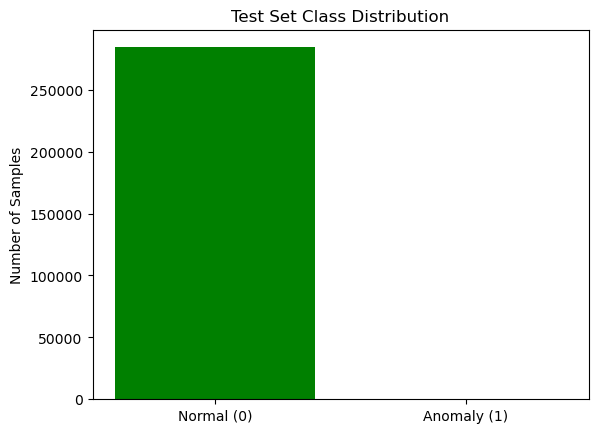

In [11]:
plt.bar(['Normal (0)', 'Anomaly (1)'], y.value_counts(), color=['green', 'red'])
plt.title("Test Set Class Distribution")
plt.ylabel("Number of Samples")
plt.show()

In [12]:
percent_anomaly = (y.value_counts()[1] / len(y)) * 100
print(f"Anomaly percentage: {percent_anomaly:.2f}%")

Anomaly percentage: 0.17%


In [13]:
#Added this section to balance test set for evaluation purpose
X_normal_sampled = X_train[y_train == 0].sample(n=492, random_state=42)
X_train_remaining = X_train.drop(X_normal_sampled.index)
y_train_remaining = y_train.drop(X_normal_sampled.index)

X_test_balanced = pd.concat([X_normal_sampled, X_test])
y_test_balanced = np.concatenate([np.zeros(492), np.ones(y_test.shape[0])])

# Convert y_test_balanced to a pandas Series with the same index as X_test_balanced
y_test_balanced = pd.Series(y_test_balanced, index=X_test_balanced.index)

X_train = X_train_remaining
y_train = y_train_remaining

X_test = X_test_balanced
y_test = y_test_balanced


print(y_test.value_counts())

0.0    492
1.0    492
dtype: int64


In [14]:
print("Total rows in X_test:", X_test.shape[0])  # Total rows in X_test after sampling
print("Total rows in X_train:", X_train.shape[0])  # Total rows in X_train after sampling
print("Total rows in X_train for normal instances (y == 0):", X_train[y_train == 0].shape[0]) 
print("Total rows in X_train for anomaly instances (y == 1):", X_train[y_train == 1].shape[0])

Total rows in X_test: 984
Total rows in X_train: 283823
Total rows in X_train for normal instances (y == 0): 283823
Total rows in X_train for anomaly instances (y == 1): 0


### Training the Autoencoder

In [15]:
start_time = time.time()

input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoder = Dense(int(input_dim / 2), activation='relu', activity_regularizer=regularizers.l1(10e-7))(input_layer)
encoder = Dense(int(input_dim / 4), activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)

decoder = Dense(int(input_dim / 2), activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)
decoder = Dense(input_dim, activation='sigmoid', kernel_regularizer=regularizers.l2(10e-7))(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = autoencoder.fit(X_train, X_train, epochs=1000, batch_size=64, shuffle=True,
                 validation_split=0.1, verbose=2, callbacks=[earlystopper])

end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

print(f"Execution Time: {execution_time:.4f} seconds")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 14)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           105 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 14)             │           112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 29)             │           435 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072 (4.19 KB)

 Trainable params: 1,072 (4.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
3992/3992 - 10s - 2ms/step - loss: 0.0026 - mse: 0.0024 - val_loss: 0.0013 - val_mse: 0.0012
Epoch 2/1000
3992/3992 - 9s - 2ms/step - loss: 0.0011 - mse: 0.0010 - val_loss: 9.1829e-04 - val_mse: 8.2908e-04
Epoch 3/1000
3992/3992 - 7s - 2ms/step - loss: 8.8001e-04 - mse: 7.9092e-04 - val_loss: 8.0953e-04 - val_mse: 7.2213e-04
Epoch 4/1000
3992/3992 - 9s - 2ms/step - loss: 8.3496e-04 - mse: 7.5029e-04 - val_loss: 7.9011e-04 - val_mse: 7.0653e-04
Epoch 5/1000
3992/3992 - 8s - 2ms/step - loss: 8.2457e-04 - mse: 7.4338e-04 - val_loss: 7.8726e-04 - val_mse: 7.0646e-04
Epoch 6/1000
3992/3992 - 9s - 2ms/step - loss: 8.1773e-04 - mse: 7.3770e-04 - val_loss: 7.7174e-04 - val_mse: 6.9199e-04
Epoch 7/1000
3992/3992 - 7s - 2ms/step - loss: 8.0867e-04 - mse: 7.2762e-04 - val_loss: 7.6661e-04 - val_mse: 6.8310e-04
Epoch 8/1000
3992/3992 - 9s - 2ms/step - loss: 7.9724e-04 - mse: 7.1416e-04 - val_loss: 7.6997e-04 - val_mse: 6.8591e-04
Epoch 9/1000
3992/3992 - 7s - 2ms/step - loss: 7.8873e-

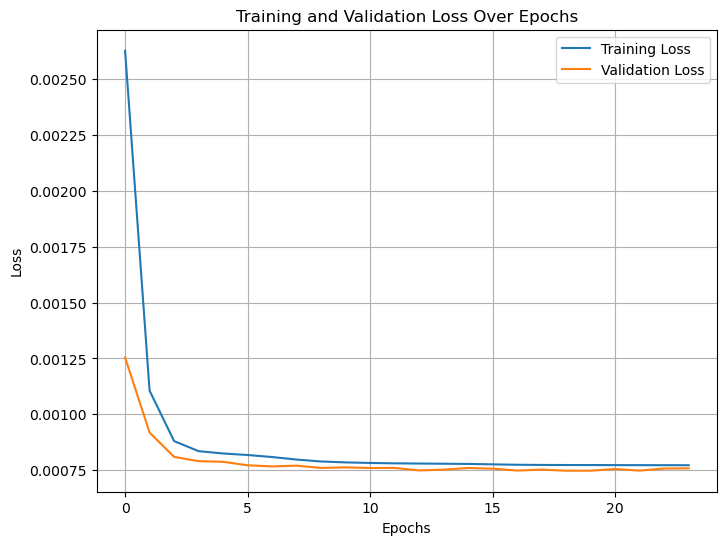

In [16]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate the autoencoder for anomaly detection.

In [17]:
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

train_recon_error = np.mean(np.square(X_train - X_train_pred), axis=1)
test_recon_error = np.mean(np.square(X_test - X_test_pred), axis=1)

threshold = np.percentile(train_recon_error, 95)
y_pred = [1 if e > threshold else 0 for e in test_recon_error]

8870/8870 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


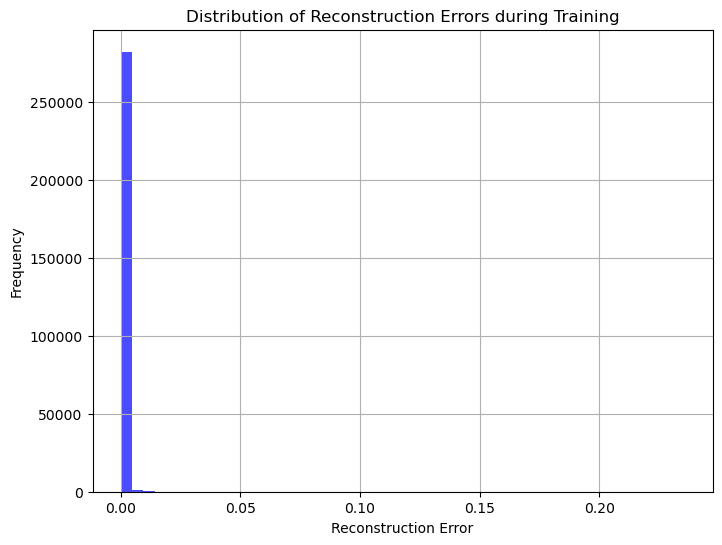

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(train_recon_error, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Reconstruction Errors during Training')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


# Precision, Recall, F1-Score for anomaly detection
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print individual scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report for a detailed overview
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[474  18]
 [ 64 428]]
Precision: 0.9596
Recall: 0.8699
F1-Score: 0.9126
              precision    recall  f1-score   support

         0.0       0.88      0.96      0.92       492
         1.0       0.96      0.87      0.91       492

    accuracy                           0.92       984
   macro avg       0.92      0.92      0.92       984
weighted avg       0.92      0.92      0.92       984



In [20]:
fpr, tpr, thresholds = roc_curve(y_test, test_recon_error)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

AUC: 0.9551


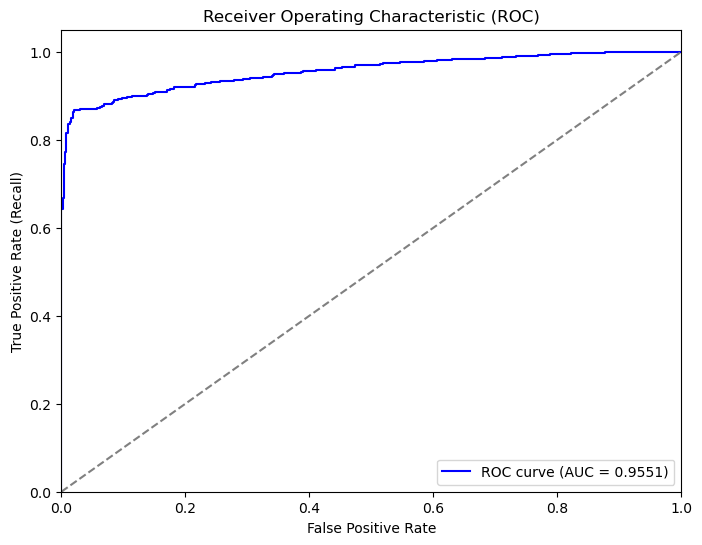

In [21]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

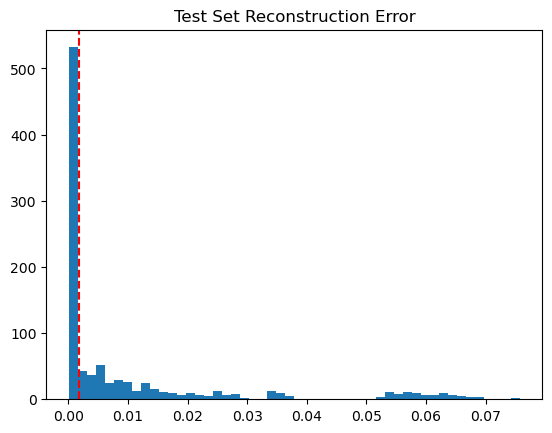

In [22]:
plt.hist(test_recon_error, bins=50)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Test Set Reconstruction Error")
plt.show()

### Getting Top Anomalies

In [23]:
# Get top 10 anomalies for explanation

#predictions = autoencoder.predict(X_test)
square_errors = np.power(X_test - X_test_pred, 2)
mse_series = pd.Series(np.mean(square_errors, axis=1))

most_anomal_trx = mse_series.sort_values(ascending=False)
columns = ["id", "mse_all_columns"]
columns.extend(["squared_error_" + x for x in list(X_test.columns)])

items = []
for x in most_anomal_trx.iteritems():
    item = [x[0], x[1]]
    item.extend(square_errors.loc[x[0]])
    items.append(item)

df_anomalies = pd.DataFrame(items, columns=columns)
df_anomalies.set_index('id', inplace=True)

top_anomalies_to_explain = df_anomalies.head(10).index  # Heden anomaly explain hiihee songoh

C:\Users\Zaya\AppData\Local\Temp\ipykernel_5040\1775725352.py:12: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for x in most_anomal_trx.iteritems():


In [24]:
df_anomalies.head(10)

,mse_all_columns,squared_error_V1,squared_error_V2,squared_error_V3,squared_error_V4,squared_error_V5,squared_error_V6,squared_error_V7,squared_error_V8,squared_error_V9,...,squared_error_V20,squared_error_V21,squared_error_V22,squared_error_V23,squared_error_V24,squared_error_V25,squared_error_V26,squared_error_V27,squared_error_V28,squared_error_Amount
id,,,,,,,,,,,,,,,,,,,,,
154684,0.075743,0.233523,0.057079,0.240620,0.142315,0.016730,0.002320,0.069754,0.199439,0.214689,...,0.014456,0.135382,0.136353,6.760065e-03,9.153295e-04,5.961251e-03,0.004596,0.011608,8.305768e-05,1.250548e-05
154587,0.074983,0.226426,0.054016,0.223957,0.131134,0.014939,0.002103,0.063393,0.179757,0.219198,...,0.012929,0.119669,0.139400,5.513774e-03,5.233349e-03,5.941558e-03,0.003574,0.010519,1.639990e-05,1.249800e-05
150647,0.069515,0.003348,0.004156,0.025778,0.149397,0.001354,0.001740,0.004012,0.000815,0.028329,...,0.000281,0.001450,0.001072,2.061049e-06,1.017841e-03,2.965462e-04,0.003079,0.000806,2.789406e-04,1.011930e-05
150654,0.069105,0.003608,0.004785,0.032009,0.151335,0.001468,0.002109,0.004012,0.000967,0.032562,...,0.000226,0.001360,0.000143,6.962077e-05,2.406082e-03,1.516458e-03,0.004223,0.000538,2.308785e-04,1.234356e-05
42528,0.069078,0.005560,0.003681,0.017215,0.079615,0.002180,0.000805,0.002365,0.000688,0.058316,...,0.000411,0.001406,0.000260,1.519642e-05,3.126351e-03,5.939592e-04,0.004378,0.001377,3.591630e-04,9.470847e-05
150601,0.067530,0.002768,0.002760,0.021412,0.017118,0.001063,0.002887,0.003041,0.000314,0.009511,...,0.000331,0.001204,0.000272,4.591616e-06,1.228514e-03,1.409479e-03,0.006820,0.001312,4.182239e-04,1.205212e-05
150684,0.067066,0.028312,0.004974,0.049469,0.080605,0.003267,0.001912,0.005171,0.003783,0.037814,...,0.000002,0.002271,0.002485,1.769877e-05,6.460714e-04,1.052998e-03,0.003782,0.000068,3.165413e-08,1.196372e-05
150644,0.066894,0.003576,0.004547,0.028005,0.053559,0.000955,0.002857,0.002479,0.000342,0.035578,...,0.000207,0.001010,0.000243,2.804017e-07,3.710085e-03,8.386168e-04,0.015624,0.000997,4.015129e-04,3.407732e-07
41943,0.066700,0.001089,0.002462,0.024143,0.015141,0.001220,0.002792,0.003145,0.000304,0.017998,...,0.000428,0.000945,0.000344,4.695962e-06,2.214841e-03,6.509483e-03,0.004447,0.001645,4.794513e-04,1.210323e-05


In [25]:
df_anomalies.shape

(984, 30)

In [26]:
top_anomalies_to_explain

Int64Index([154684, 154587, 150647, 150654, 42528, 150601, 150684, 150644,
            41943, 42635],
           dtype='int64', name='id')

### Errors Data Frame per Record

In [27]:
def get_errors_df_per_record(record):
    prediction = autoencoder.predict(np.array([[record]])[0])[0]
    square_errors = np.power(record - prediction, 2)
    errors_df = pd.DataFrame({'col_name': square_errors.index, 'err': square_errors}).reset_index(drop=True)
    total_mse = np.mean(square_errors)
    errors_df.sort_values(by='err', ascending=False, inplace=True)
    return errors_df, total_mse

### Calculating Features with Highest Reconstruction Error

In [28]:
def get_num_features_with_highest_reconstruction_error(total_squared_error, errors_df):
    error = 0
    for num_of_features, index in enumerate(errors_df.index):
        error += errors_df.loc[index, 'err']
        print("------------Error---------------")
        print(error)
        if error >= 0.5 * total_squared_error:  # 0.5 is the default reconstruction_error_percent
            break
    return num_of_features + 1

### Set Explain with LIME

In [29]:
# AnchorXAI explanation function
def explain_with_anchor(record, num_of_features, X_train, model):
    # Initialize the AnchorTabular explainer
    explainer = AnchorTabular(model.predict, X_train.columns)
    explainer.fit(X_train.values, disc_perc=[25, 50, 75])  # Fit the explainer on the training data

    # Explaining the record using AnchorXAI
    explanation = explainer.explain_instance(record.values, threshold=0.95)  
    
    # Convert the explanation into a DataFrame for easier manipulation
    explanation_df = pd.DataFrame(explanation.names(), columns=['Feature'])
    return explanation_df

### Main Function

In [30]:
def main():
    all_sets_explaining_features = {}

    for record_idx in top_anomalies_to_explain[:3]:  # Process only the first 3 anomalies
        record_to_explain = X_test.loc[record_idx]
        
        # Get reconstruction errors and total MSE
        df_err, total_mse = get_errors_df_per_record(record_to_explain)
        
        # Get the number of features contributing to reconstruction error
        num_of_features = get_num_features_with_highest_reconstruction_error(
            total_mse * df_err.shape[0], df_err
        )
        
        # Get top 'num_of_features' by error
        df_top_err = df_err.head(num_of_features)
        
        # Use AnchorXAI for explanation
        explanation_df = explain_with_anchor(record_to_explain, num_of_features, X_train, autoencoder)

        # Update the dictionary with features explaining the record
        all_sets_explaining_features[record_idx] = explanation_df
        
        # Print formatted explanation for each record
        print(f"\nExplanation for Record {record_idx}:")
        print("-" * 50)
        for index, row in explanation_df.iterrows():
            print(f"Feature: {row['Feature']}")
        print("-" * 50)
    
    # Final results
    print("\nCompleted processing the top 3 anomalies.")
    print(all_sets_explaining_features)
    

if __name__ == "__main__":
    
    start_time = time.time()
    main()
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time

    print(f"Execution Time: {execution_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
------------Error---------------
0.259398079762466
------------Error---------------
0.500018271404838
------------Error---------------
0.7335416291180131
------------Error---------------
0.9482305847573647
------------Error---------------
1.1476696152962398
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Explanation for Record 154684:
--------------------------------------------------
Feature: V19 <= 0.53, LIME Contribution: -0.0005
Feature: V15 <= 0.29, LIME Contribution: -0.0003
Feature: V13 <= 0.40, LIME Contribution: 0.0003
Feature: V4 > 0.28, LIME Contribution: -0.0002
Feature: V18 <= 0.62, LIME Contribution: -0.0002
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
------------Error---------------
0.25549820868311157
------------Error---------------
0.48192377931720654
------------Error---------------
0.7058808823666575
------------Error---------------
0.9250784464601781
------------Error---------------
1.1048